<a href="https://www.kaggle.com/code/mdrahimuddin/ct-scan-covid-19-dataset-using-resnet152?scriptVersionId=117171804" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n1637.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n770.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n1927.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n545.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n816.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n677.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n1934.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n1510.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n2042.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n1150.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n1609.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n1854.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n781.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n650.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n1545.jpg
/kaggle/input/covid-ct/Covid_CT/test_data/Non_COVID/n737.jpg
/kaggle/input/c

In [2]:
import os
import numpy as np # linear algebra
import shutil

In [3]:
!pip install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=091ad532e6177ac71fc50921b48004b668c316888137049f9ea668e6670e686e
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [4]:
from imutils import paths
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import itertools

# 1- Data preparation

In [5]:
data_dir  = '../input/covid-ct'
data_list = sorted(list(paths.list_images(data_dir)))

random.seed(99)
random.shuffle(data_list)

In [6]:
#define
TEST_SIZE=0.14

#Split the data into two groups (training/validation and testing)
train_filenames, test_filenames = train_test_split(data_list, test_size=TEST_SIZE)

print('Number of Train/Valid data:',len(train_filenames))
print('Number of Test data ------:',len(test_filenames))

Number of Train/Valid data: 12454
Number of Test data ------: 2028


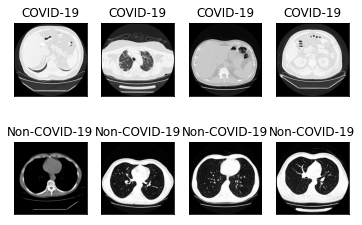

In [7]:
#create sample data and show them:

sample_imgs=[]
sample_labels=[]

tmp = sorted(list(paths.list_images('../input/covid-ct/Covid_CT/train_data/COVID')))
random.shuffle(tmp)
for X in tmp[:4]:
    sample_imgs.append(cv2.imread(X))
    sample_labels.append('COVID-19')
        
tmp = sorted(list(paths.list_images('../input/covid-ct/Covid_CT/train_data/Non_COVID')))
random.shuffle(tmp)
for X in tmp[:4]:
    sample_imgs.append(cv2.imread(X))
    sample_labels.append('Non-COVID-19')     


for i in range(0, 8):
    plt.subplot(2 , 4 , i+1)
    plt.imshow(sample_imgs[i+0])
    plt.title(sample_labels[i+0])
    plt.xticks([]),plt.yticks([])
    # show the plot
plt.show()

# 2- Create pre-processing and augmentation pipeline

In [8]:
#set the directories 
TRAIN_DATA_DIR = "../input/covid-ct/Covid_CT/train_data"
TEST_DATA_DIR  = "../input/covid-ct/Covid_CT/test_data"

In [9]:
#defines 

IMG_HIGHT, IMG_WIDTH = 255,255
BATCH_SIZE = 32
VALID_SPLIT = 0.17

In [10]:
#set the Pipeline with ImageDataGenerator(real-time data augmentation)
datagen = ImageDataGenerator(validation_split= VALID_SPLIT,      #Split Validation
                             rescale=1./255,                    #Rescale to float
                             #featurewise_center=True,
                             #featurewise_std_normalization=True, 
                             samplewise_center=True,            #Set each sample mean to 0.
                             samplewise_std_normalization=True, #Divide each input by its std. 
                             vertical_flip=True,                #Augmentation
                             horizontal_flip=True,              #Augmentation
                             rotation_range=30                  #Augmentation,random rotations.
)
#datagen.fit(sample_imgs)
#print(datagen.mean)
#print(datagen.std)

In [11]:
#set the Training and Vaidation Generators:

TRAIN_GEN = datagen.flow_from_directory(
            TRAIN_DATA_DIR,
            target_size=(IMG_HIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            subset='training',
            shuffle=True,
            #color_mode="grayscale",
            seed=99
)
VALID_GEN = datagen.flow_from_directory(
            TRAIN_DATA_DIR,
            target_size=(IMG_HIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            subset='validation',
            shuffle=True,
            #color_mode="grayscale",
            seed=99
)

Found 10217 images belonging to 2 classes.
Found 2092 images belonging to 2 classes.


32


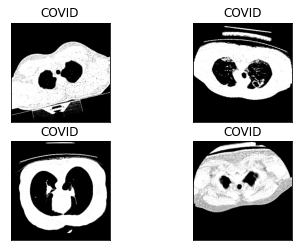

In [12]:
#Show random picture after the Augmentation and Normalization:

for X_batch, y_batch in TRAIN_GEN:
    print(len(y_batch))
    # create a grid of 3x3 images
    for i in range(0, 4):
        plt.subplot(2 , 2 , i+1)
        plt.imshow(X_batch[i])
        plt.title('COVID' if y_batch[i]==0 else 'Non_COVID')
        plt.xticks([]),plt.yticks([])
    # show the plot
    plt.show()
    break

In [13]:
#create the pipeline and generator for Test data:

t_datagen = ImageDataGenerator(rescale=1./255,
                               #featurewise_center=True,
                               #featurewise_std_normalization=True
                               samplewise_std_normalization=True,
                               samplewise_center=True
)

TEST_GEN = t_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_HIGHT, IMG_WIDTH),
    batch_size=2028,
    class_mode='binary',
    shuffle=True,
    seed=99
)

Found 2173 images belonging to 2 classes.


# 3- Create the Model

In [14]:
#defines:

LEARNING_RATE = 0.00001
EPOCHS = 30
LOSS = 'sparse_categorical_crossentropy'
METRIC = 'accuracy'

In [15]:
#set the model:

base = tf.keras.applications.resnet.ResNet152(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HIGHT, IMG_WIDTH, 3)
)

x = base.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform')(x)
y = tf.keras.layers.Dropout(0.3)(x)

prediction = tf.keras.layers.Dense(2, activation='softmax')(y)

model = Model(inputs= base.input, outputs= prediction)
#model.summary()

2023-01-24 09:20:02.665277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 09:20:02.759736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 09:20:02.760774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 09:20:02.763112: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

234708992/234698864 [==============================] - 1s 0us/step


In [16]:
#Compile the model:

model.compile(optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              loss      = LOSS,
              metrics   = [METRIC])

In [17]:
STEP_SIZE_TRAIN=TRAIN_GEN.n//TRAIN_GEN.batch_size
print('full steps number:', STEP_SIZE_TRAIN)

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5) #early stopping

full steps number: 319


In [18]:
#Train the model:

trainer= model.fit(TRAIN_GEN,
                   validation_data= VALID_GEN,
                   epochs=15,
                   steps_per_epoch=319,
                   verbose=2,
                   callbacks=[early])

2023-01-24 09:20:11.189459: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-24 09:20:27.734202: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


319/319 - 361s - loss: 1.0233 - accuracy: 0.6481 - val_loss: 2.2285 - val_accuracy: 0.2629
Epoch 2/15
319/319 - 296s - loss: 0.3993 - accuracy: 0.9177 - val_loss: 1.0145 - val_accuracy: 0.5693
Epoch 3/15
319/319 - 296s - loss: 0.3059 - accuracy: 0.9593 - val_loss: 0.8657 - val_accuracy: 0.6683
Epoch 4/15
319/319 - 296s - loss: 0.2621 - accuracy: 0.9737 - val_loss: 0.8811 - val_accuracy: 0.6797
Epoch 5/15
319/319 - 299s - loss: 0.2451 - accuracy: 0.9791 - val_loss: 0.2148 - val_accuracy: 0.9857
Epoch 6/15
319/319 - 296s - loss: 0.2383 - accuracy: 0.9817 - val_loss: 0.1954 - val_accuracy: 0.9957
Epoch 7/15
319/319 - 295s - loss: 0.2191 - accuracy: 0.9883 - val_loss: 0.1896 - val_accuracy: 0.9976
Epoch 8/15
319/319 - 295s - loss: 0.2174 - accuracy: 0.9890 - val_loss: 0.1883 - val_accuracy: 0.9971
Epoch 9/15
319/319 - 296s - loss: 0.2077 - accuracy: 0.9914 - val_loss: 0.1865 - val_accuracy: 0.9971
Epoch 10/15
319/319 - 297s - loss: 0.2072 - accuracy: 0.9915 - val_loss: 0.1860 - val_accurac

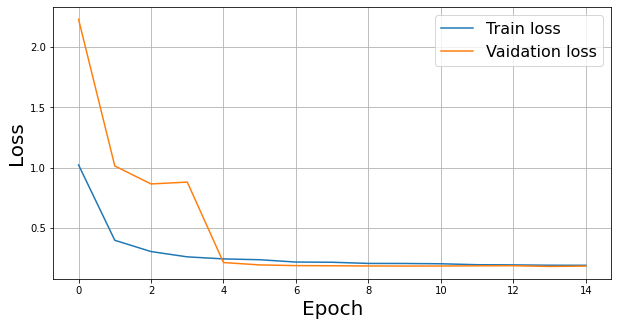

In [19]:
# Plotting train_loss vs val_loss:

plt.figure(figsize=(10,5))
plt.plot(trainer.history["loss"],label="Train loss")
plt.plot(trainer.history["val_loss"],label="Vaidation loss")
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend( loc ="upper right",fontsize=16)
plt.grid()

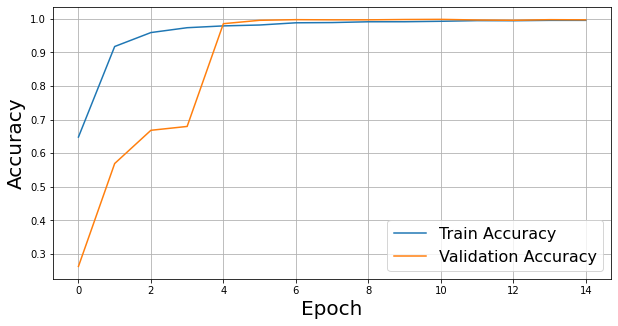

In [20]:
# Plotting train_accuracy vs Val_accuracy:

plt.figure(figsize=(10,5))
plt.plot(trainer.history["accuracy"],label="Train Accuracy")
plt.plot(trainer.history["val_accuracy"],label="Validation Accuracy")
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(loc='lower right',fontsize=16)
plt.grid()

In [21]:
for X_batch, y_batch in TEST_GEN:
    y_test = y_batch
    X_test = X_batch
    break
    
print('test label shape',y_test.shape)
print('test image shape',X_test.shape)
print('Evaluate on test-data:')
model.evaluate(X_test,y_test)

test label shape (2028,)
test image shape (2028, 255, 255, 3)
Evaluate on test-data:


2023-01-24 10:38:23.132670: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1582448400 exceeds 10% of free system memory.
2023-01-24 10:38:24.970702: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1582448400 exceeds 10% of free system memory.


64/64 [==============================] - 13s 164ms/step - loss: 0.1835 - accuracy: 0.9985


[0.18351410329341888, 0.9985207319259644]

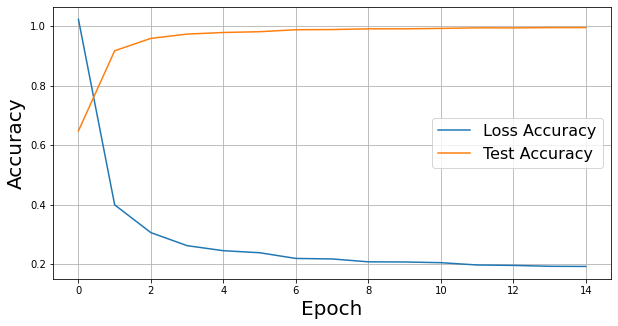

In [22]:
# Plotting loss_accuracy vs Test_accuracy:

plt.figure(figsize=(10,5))
plt.plot(trainer.history["loss"],label="Loss Accuracy")
plt.plot(trainer.history["accuracy"],label="Test Accuracy")
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(loc='center right',fontsize=16)
plt.grid()

In [23]:
pred = model.predict(X_test)
bin_predict = np.argmax(pred,axis=1)

#Confusion matrix:
matrix = confusion_matrix(y_test, bin_predict)
print('Confusion Matrix:\n',matrix)

2023-01-24 10:38:49.635590: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1582448400 exceeds 10% of free system memory.
2023-01-24 10:38:51.380688: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1582448400 exceeds 10% of free system memory.


Confusion Matrix:
 [[1711    2]
 [   1  314]]


In [24]:
#Plot the Confusion matrix:
def plot_confusion_matrix(cm,
                          target_names,
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="white")
    if cmap is None:
        cmap = plt.get_cmap('Dark2_r')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names,  fontsize=15)
        plt.yticks(tick_marks, target_names, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "red")


    plt.tight_layout()
    #plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass), fontsize=20)
    plt.show()

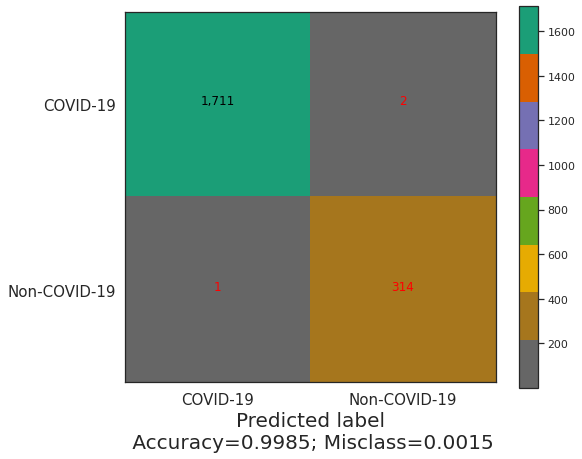

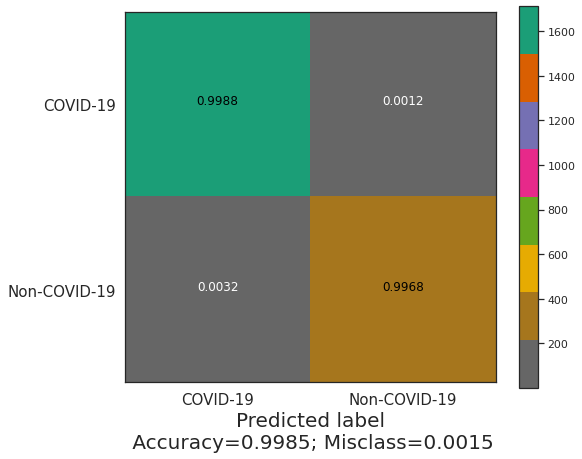

In [25]:
plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = False,
                      target_names = ['COVID-19','Non-COVID-19']
                      )

plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = True,
                      target_names = ['COVID-19','Non-COVID-19']
                      )

In [26]:
class_metrics = metrics.classification_report(y_test,bin_predict,labels=[0, 1])
print(class_metrics)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1713
           1       0.99      1.00      1.00       315

    accuracy                           1.00      2028
   macro avg       1.00      1.00      1.00      2028
weighted avg       1.00      1.00      1.00      2028



In [27]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MAE = mean_absolute_error(y_test, bin_predict)

print('MAE:', MAE)
print('Accuracy:', ACC)
print('Precision (positive predictive value):', PPV)
print('Recall (Sensitivity, hit rate, true positive rate):', TPR)
print('Specificity (true negative rate):', TNR)
print('Negative Predictive Value:', NPV)
print('Fall out (false positive rate):', FPR)
print('False Negative Rate:', FNR)
print('False discovery rate:', FDR)

Other Metrics:
MAE: 0.0014792899408284023
Accuracy: [0.99852071 0.99852071]
Precision (positive predictive value): [0.99941589 0.99367089]
Recall (Sensitivity, hit rate, true positive rate): [0.99883246 0.9968254 ]
Specificity (true negative rate): [0.9968254  0.99883246]
Negative Predictive Value: [0.99367089 0.99941589]
Fall out (false positive rate): [0.0031746  0.00116754]
False Negative Rate: [0.00116754 0.0031746 ]
False discovery rate: [0.00058411 0.00632911]
